# scRNA-seq Analysis of a Human Blood-Derived Immune Cell Dataset

## 1. Overview

This project implements an end-to-end single-cell RNA-seq (scRNA-seq) analysis workflow in Python using Scanpy.  
The analysis starts from a count matrix stored in an `.h5ad` file (`bone_marrow.h5ad`) and performs:

- Quality control (QC) and doublet detection
- Normalization and log-transformation
- Highly variable gene (HVG) selection
- Dimensionality reduction (PCA, UMAP)
- Graph-based clustering (Leiden)
- Cell-type scoring using decoupler and PanglaoDB marker signatures
- Manual cluster annotation and biological interpretation

Although the file is named `bone_marrow.h5ad`, the final cell-type composition is more consistent with a **blood-derived immune cell dataset (PBMC-like / peripheral blood leukocytes)** than classical bone marrow. The analysis therefore serves two purposes:

1. Provide a clean, reusable scRNA-seq analysis pipeline.
2. Infer and justify the underlying tissue/source from the resulting cellular landscape.

---

## 2. Environment and Installation

### 2.1. Requirements

Core Python packages:

- `scanpy`
- `anndata`
- `pandas`
- `numpy`
- `scipy`
- `matplotlib`
- `seaborn`
- `decoupler`
- `scrublet`
- `igraph`            (backend for Leiden clustering)
- `celltypist`        (optional, alternative annotation)
- `fa2-modified`      (optional, for graph layouts)



###2.2. Setup

#### Create and activate a virtual environment (optional but recommended)
    python -m venv .venv
    source .venv/bin/activate    # Linux/macOS
    # .venv\Scripts\activate      # Windows

#### Install dependencies
pip install -r requirements.txt
Once installed, open and run the notebook:
scRNA_seq_data_analysis_Lavinia2.ipynb

----

## 3. Data

###3.1. Input format
The workflow expects a single AnnData object in .h5ad format:

     bone_marrow.h5ad

Content:
    
    .X: raw counts (cells × genes), or raw counts in .layers["counts"]
    .obs: per-cell metadata (will be augmented by QC, doublet scores, clusters, etc.)
    .var: per-gene metadata, including a gene symbol column (e.g. gene_symbols or feature_name)

###3.2. Important note on dataset naming
Despite the filename, the analysis shows that the sample behaves more like a peripheral blood / PBMC immune dataset than canonical bone marrow. This conclusion is based on:

- Observed cell-type composition
- Lack of strong stem/progenitor and erythroid compartments
- Agreement with known PBMC scRNA-seq profiles

This is documented in the Findings section below.

---

## 4. Analysis Workflow
This section summarizes the complete scRNA-seq analysis pipeline implemented in the notebook.

###4.1. Data loading and identifier standardization
Load the count matrix as an AnnData object from bone_marrow.h5ad using scanpy.read_h5ad.

Ensure unique gene and cell identifiers:
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

Why it matters:
Non-unique cell or gene identifiers break indexing and downstream operations. Standardizing names is required for a robust, reproducible pipeline.


###4.2. Gene-level QC flags and per-cell QC metrics
Select a gene symbol column from .var (e.g. gene_symbols or feature_name) and convert to upper case.

Define gene categories:
- Mitochondrial genes: symbols starting with MT-
- Ribosomal genes: symbols starting with RPS or RPL
- Hemoglobin genes: predefined list, e.g. HBA1, HBA2, HBB, HBD, HBG1, HBG2

Compute per-cell QC metrics using:

    sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=['MT', 'RIBO', 'HB'],
    inplace=True
        )

This produces, among others:

    n_genes_by_counts
    total_counts
    pct_counts_MT
    pct_counts_RIBO
    pct_counts_HB (if hemoglobin genes are present)

Why it matters:
These metrics identify low-quality cells (few genes, low counts, high mitochondrial percentage) and potential technical biases that should be removed before clustering.

###4.3. Doublet detection with Scrublet

    Extract raw counts from .X or .layers["counts"].

Run Scrublet:

    scrub = scr.Scrublet(counts_matrix, expected_doublet_rate=0.06)
    doublet_scores, predicted_doublets = scrub.scrub_doublets()

Store results in per-cell metadata:

    adata.obs['doublet_score'] = doublet_scores
    adata.obs['predicted_doublet'] = predicted_doublets

Why it matters:
Doublets (two cells in one droplet) produce hybrid expression profiles and can form artificial “mixed” clusters, especially at higher resolution. Flagging or removing them improves cluster purity and interpretability.


###4.4. Cell-level QC filtering
Define thresholds based on QC plots (violins, scatterplots):

Examples (to be tuned to the dataset):

- n_genes_by_counts: minimum and maximum range (e.g. 200–5000)
- total_counts: minimum and maximum range (e.g. 500–50,000)
- pct_counts_MT: maximum allowed mitochondrial percentage (e.g. ≤ 20%)

Construct a boolean mask:

    cell_mask = (
      (adata.obs['n_genes_by_counts'] >= MIN_GENES) &
      (adata.obs['n_genes_by_counts'] <= MAX_GENES) &
     (adata.obs['total_counts'] >= MIN_COUNTS) &
     (adata.obs['total_counts'] <= MAX_COUNTS) &
      (adata.obs['pct_counts_MT'] <= MAX_MT)
    )

Subset the object:

    adata = adata[cell_mask].copy()

Optionally remove doublets:

    adata = adata[adata.obs['predicted_doublet'] == False].copy()

Why it matters:
Filtering ensures the downstream analysis is performed on high-quality singlet cells, reducing noise and artifactual structure.

###4.5. Normalization, log-transform, and highly variable genes (HVGs)

Save raw counts for reference:

    adata.layers['counts'] = adata.X.copy()

Normalize and log-transform:

    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)

Identify highly variable genes:

    sc.pp.highly_variable_genes(adata, n_top_genes=2000, flavor='seurat_v3')
    adata = adata[:, adata.var['highly_variable']].copy()

Why it matters:
Normalization and log-transformation stabilize the variance structure, while restricting to HVGs focuses the analysis on informative genes and improves downstream dimensionality reduction and clustering.

###4.6. PCA, neighborhood graph, UMAP, and Leiden clustering

Run PCA on the HVG expression matrix:

    sc.tl.pca(adata, svd_solver='arpack')

Construct a k-nearest neighbor graph:

    sc.pp.neighbors(adata, n_neighbors=15, n_pcs=30, random_state=0)

Compute UMAP embedding:

    sc.tl.umap(adata, random_state=0)

Run Leiden clustering at one or more resolutions (e.g. 0.02, 0.5, 2.0):

    sc.tl.leiden(adata, resolution=0.5, key_added='leiden_res0_5')

Why it matters:
PCA and neighbors capture the main structure of variation. UMAP provides a 2D visualization of this manifold, and Leiden clustering identifies transcriptionally similar cell groups (candidate cell types or states).

###4.7. Cell-type scoring with decoupler and PanglaoDB

Retrieve PanglaoDB marker signatures via decoupler.

Convert the marker table into a network format with columns:
- source: cell type
- target: gene symbol

Run the ULM method:

    dc.mt.ulm(data=adata, net=markers, tmin=3)

This stores per-cell activity scores for each cell-type signature in adata.obsm ['score_ulm'].

Aggregate scores at cluster level using dotplots or matrixplots to see which signatures dominate each Leiden cluster.

Why it matters:
Cell-type scoring provides a reference-based, quantitative measure of how strongly each cell or cluster matches known cell-type programs (e.g. neutrophils, monocytes, B cells, T/NK cells), instead of relying on a few manually chosen markers.

###4.8. Differential expression and marker-based validation
Use sc.tl.rank_genes_groups to find marker genes per cluster.

Compare top-ranked genes with canonical lineage markers:
- Neutrophils (e.g. S100A8, S100A9, LST1)
- Monocytes/macrophages (myeloid markers)
- B cells (e.g. MS4A1, CD79A)
- T/NK cells (e.g. CD3D, TRAC, NKG7, GNLY)

Why it matters:
Differential expression validates cell-type assignments and refines cluster identities beyond what signature scoring alone can provide.

###4.9. Cluster annotation
Choose a main clustering resolution (e.g. leiden_res0_5).

Combine:
- decoupler-derived cell-type scores
- cluster-level marker genes
- known immunology of blood/bone marrow

Define a mapping:

    cluster_to_celltype = {
       "0": "Neutrophils",
      "1": "Monocytes / Macrophages",
      "2": "B cells",
      "3": "T / NK cells",
      "4": "Dendritic cells",
       "5": "Other / rare population",
    }
Apply it:

    adata.obs['cell_type'] = (
    adata.obs['leiden_res0_5'].map(cluster_to_celltype)
    ).astype('category')

Why it matters:
Cluster annotation translates numeric cluster IDs into interpretable biological populations, enabling comparison to external datasets and literature.

###4.10. Interpretation and dataset-type inference

Summarize the final composition of annotated cell types.

Compare the observed mixture to reference profiles of:
- Healthy bone marrow (HSPCs, erythroid progenitors, megakaryocytes, etc.)
- PBMC / peripheral blood (mature T, B, NK, monocytes, with minimal HSPCs/erythroid cells)
- Infer whether the dataset behaves like bone marrow, PBMC, or another immune compartment, and justify this with the observed distribution.

Why it matters:
Validating the dataset’s tissue-of-origin against known biology protects against mislabeled data and strengthens the interpretation of results.

---

##5. Findings and Interpretation

###5.1. What cell types did you identify

From the final cell_type annotations and the proportion table, the dataset contains the following main cell types (collapsed across clusters):

- Nuocytes (type 2 innate lymphoid like cells)
- NK cells
- Gamma delta T cells (γδ T cells)
- Neutrophils
- Naive B cells
- Plasma cells
- Monocytes
- Platelets / platelet-like cells
- Thymocytes (immature T-cell like population)

Those are the dominant identities the decoupler/PanglaoDB + clustering pipeline resolved.


###5.2. Biological role of each cell type (concise)

- Nuocytes (ILC2-like cells) : Innate lymphoid cells that rapidly produce type 2 cytokines and help shape downstream Th2 responses.

- NK cells : Innate cytotoxic lymphocytes that kill virally infected or stressed cells without prior antigen priming.

- Gamma delta T cells (γδ T cells) : Unconventional T cells with γδ T-cell receptors that recognize non-classical ligands, bridge innate and adaptive immunity, respond rapidly to stress/infection, and can produce inflammatory cytokines or exert cytotoxicity.

- Neutrophils : Short-lived granulocytes generated in bone marrow and released into blood. First-line phagocytes that rapidly migrate to infected or damaged sites, engulf microbes.

- Naive B cells : Antigen-inexperienced B lymphocytes that circulate through blood and secondary lymphoid organs. Upon encountering antigen and T-cell help they undergo activation, class switching and differentiation into memory B cells or plasma cells.

- Plasma cells : Terminally differentiated B cells specialized for high-rate antibody secretion. They maintain humoral immunity, reside in bone marrow and secondary lymphoid tissues.

- Monocytes : Circulating myeloid cells that patrol blood and can migrate into tissues to differentiate into macrophages or dendritic cells. They phagocytose pathogens and debris and secrete inflammatory mediators.

- Platelets / platelet-like cells : Anucleate fragments derived from megakaryocytes. They mediate hemostasis and thrombosis, but also interact with leukocytes and endothelium and modulate inflammatory responses.

- Thymocytes (immature T-cell–like cells) : T-lineage cells in early or intermediate stages of differentiation (normally located in thymus).

###5.3. Is the tissue source really bone marrow?

Conclusion:
On biological grounds, the dataset is much more consistent with a peripheral blood / PBMC-like immune sample than with true bone marrow.

####5.3.1. What we actually see

- From the proportions you reported:
  - Nuocytes: 32.6 %
  -  NK cells: 23.9 %
   - γδ T cells: 14.3 %
   - Neutrophils: 8.3 %
   - Naive B cells: 7.3 %
   - Plasma cells: 5.5 %
    - Monocytes: 5.4 %
  -  Platelets: 1.8 %
   - Thymocytes: 0.8 %

- Key features:
  - Dominance of mature lymphoid and innate lymphoid populations.
  - Presence of mature myeloid cells (neutrophils, monocytes, DC-like signatures).
   - Modest plasma cell and platelet compartments.
  -  No clear, large CD34+ HSPC cluster and no obvious multi-stage erythroid progenitor / erythroblast series with strong hemoglobin expression.

####5.3.2. What true bone marrow should look like

- Healthy bone marrow single-cell profiles typically include:
  - A substantial hematopoietic stem and progenitor cell (HSPC) compartment (CD34+, early progenitors).
  - Multiple erythroid progenitor and maturation clusters (proerythroblasts → erythroblasts → reticulocytes) with high globin expression.
  - Megakaryocyte progenitors in addition to platelets.
  - A mixture of developing and mature lymphoid and myeloid cells.

In other words, bone marrow is characterized not just by mature immune cells but by visible differentiation hierarchies, especially HSPCs and erythroid lineages.

####5.3.3. Comparison

The dataset is dominated by mature immune effectors (innate lymphoid, NK, γδ T, neutrophils, monocytes, B, plasma, platelets) and lacks a robust HSPC or erythroid progenitor architecture.

This pattern matches blood / PBMC-type samples, where one expects mainly mature T, B, NK, monocytes, neutrophils, small plasma-cell fractions and platelets, with very few progenitors.

Therefore, despite the file name, the most biologically coherent interpretation is:
  - The sample represents a blood-derived immune cell compartment (PBMC-like / peripheral leukocytes) rather than canonical bone marrow.


###5.4. Based on the relative abundance of cell types, is the patient healthy or infected?

- Given the proportions:
  -  Neutrophils: 8.3 %
  - Monocytes: 5.4 %
  - Combined myeloid (neutrophils + monocytes): ~13.7 %
  -  NK cells: 23.9 %
  - Nuocytes + NK + γδ T (innate/innate-like lymphoid): ~71 %
  - Naive B + plasma cells: ~12.8 %
  -  Thymocyte-like: 0.8 %


####5.4.1. What an acute infected / highly inflamed profile would look like

In acute systemic infection or strong inflammatory states typically we would see, in blood:
- Neutrophilia and/or inflammatory monocyte expansion, neutrophils and monocytes becoming a very large fraction of total leukocytes.
- Often relative lymphopenia (drop in total lymphocyte fraction).
- NK and CD8 T cells may be highly activated and sometimes expanded, but usually in the context of a strong myeloid response and/or global IFN signature.


####5.4.2. What the proportions suggest

- Neutrophils and monocytes are not expanded: together they are ~14 %, not the dominant population. There is no myeloid takeover that would flag severe acute bacterial sepsis–type physiology.
- Lymphoid / innate lymphoid populations dominate (nuocytes, NK, γδ T), and B cells + plasma cells are well represented. There is no lymphopenia; if anything, lymphoid compartments are abundant.
- A ~5–6 % plasma cell fraction indicates that the immune system has seen antigen and is producing antibodies, but this is compatible with past infection, vaccination or low-grade/chronic exposure and does not by itself prove acute infection.

There isn't an overwhelming interferon-stimulated gene signature or extremely activated NK/CD8 states across most cells, which would strengthen an “acutely infected” interpretation.


####5.4.3. Defensible call

On the basis of proportions alone:
- The absence of neutrophil/monocyte expansion and the preservation (even dominance) of lymphoid populations argue against a classic acute systemic infection profile.
- The dataset looks more like a peripheral immune compartment in a non-acutely infected or mildly activated state: robust lymphoid presence, modest myeloid fractions, some plasma cells and platelets.


#####Conclusion
Using only relative cell-type abundances, the dataset is more consistent with a non-acute/near-baseline immune state than with a frank acute infection. There may be evidence of immunological experience or mild activation (plasma cells, strong innate-like lymphoid representation), but there is no clear neutrophil/monocyte expansion or lymphocyte collapse that would justify calling this an overtly infected patient from these data alone.


####References
    *(Karolyn A. Oetjen, J. Philip McCoy, Christopher S. Hourigan. Human bone marrow assessment by single-cell RNA sequencing, mass cytometry, and flow cytometry  Published December 6, 2018. JCI Insight. 2018;3(23):e124928. https://doi.org/10.1172/jci.insight.124928.)*
     *( Xiaowei Xie, Mengyao Liu, Yawen Zhang, Bingrui Wang, Caiying Zhu, Chenchen Wang, Qing Li, Yingying Huo, Jiaojiao Guo, Changlu Xu, Linping Hu, Aiming Pang, Shihui Ma, Lina Wang, Wenbin Cao, Shulian Chen, Qiuling Li, Sudong Zhang, Xueying Zhao, Wen Zhou, Hongbo Luo, Guoguang Zheng, Erlie Jiang, Sizhou Feng, Lixiang Chen, Lihong Shi, Hui Cheng, Sha Hao, Ping Zhu, Tao Cheng, Single-cell transcriptomic landscape of human blood cells, National Science Review, Volume 8, Issue 3, March 2021, nwaa180, https://doi.org/10.1093/nsr/nwaa180)*
    *(Pellin, D., Loperfido, M., Baricordi, C. et al. A comprehensive single cell transcriptional landscape of human hematopoietic progenitors. Nat Commun 10, 2395 (2019). https://doi.org/10.1038/s41467-019-10291-0)*
    *(Oelen, R., de Vries, D.H., Brugge, H. et al. Single-cell RNA-sequencing of peripheral blood mononuclear cells reveals widespread, context-specific gene expression regulation upon pathogenic exposure. Nat Commun 13, 3267 (2022). https://doi.org/10.1038/s41467-022-30893-5)*


###5.5. Summary
A full scRNA-seq analysis pipeline was implemented, including QC, doublet detection, normalization, dimensionality reduction, clustering, and cell-type annotation.
The pipeline identified major immune cell populations and produced a coherent map of the sample’s immune composition.
Based on the cell-type landscape, the dataset is most consistent with a PBMC-like / peripheral blood leukocyte sample, not canonical bone marrow, illustrating the importance of validating metadata labels against biological evidence.

## scRNA-seq Analysis of a Human Blood-Derived Immune Cell Dataset

This notebook performs a full single-cell RNA-seq analysis workflow using Scanpy:
quality control (QC), doublet detection (Scrublet), normalization, dimensionality reduction,
clustering, cell-type annotation (using decoupler + PanglaoDB), and visualization.

The goal is to (1) produce a clean, reproducible analysis pipeline **and**
(2) infer the likely
tissue/source of the sample based on the resulting cell-type composition.


**Installations to set up Scanpy environment.**

In [4]:
!pip install scanpy
!pip install anndata
!pip3 install igraph
!pip install celltypist
!pip install decoupler
!pip install fa2-modified

## 1. Load data & basic checks

In [5]:
#--1. Load data and standardize gene/cell names

import scanpy as sc
import anndata as ad

#Load pre-processed count matrix (cells x genes)
b_marrow_adata = sc.read_h5ad("/content/bone_marrow.h5ad")
print(b_marrow_adata)

AnnData object with n_obs × n_vars = 14783 × 17374
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid'
    var: 'n_cells', 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype', 'feature_length', 'feature_type'
    uns: 'citation', 'doi', 'organism', 'organism_ontology_term_id', 'schema_reference', 'schema_version', 'title'
    obsm: 'X_pca', 'X_tsne', 'X_umap'


In [6]:
# Exploration of dataset (shape of the anndata)
b_marrow_adata.shape

(14783, 17374)

In [7]:
# Exploration of dataset (first five genes in the anndata)
b_marrow_adata.var.head()

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000161920      927                False        MED11    NCBITaxon:9606   
ENSG00000122335      429                False       SERAC1    NCBITaxon:9606   
ENSG00000175548      149                False       ALG10B    NCBITaxon:9606   
ENSG00000100330      426                False        MTMR3    NCBITaxon:9606   
ENSG00000176340     7171                False        COX8A    NCBITaxon:9606   

                feature_biotype feature_length    feature_type  
ENSG00000161920            gene            754  protein_coding  
ENSG00000122335            gene           2683  protein_coding  
ENSG00000175548            gene           1773  protein_coding  
ENSG00000100330            gene            634  protein_coding  
ENSG00000176340            gene            494  protein_coding

In [8]:
# Exploration of dataset(first five cell data)
b_marrow_adata.obs.head()

disease stage                    treatment timepoint  \
index                                                                         
Guo-AAACCTGAGAGCTTCT-2        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGAGGTTGC-7     remission  400 mg Tocilizumab at day 1     day 7   
Guo-AAACCTGAGATACACA-3     remission  400 mg Tocilizumab at day 1     day 5   
Guo-AAACCTGAGCGATTCT-1        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGTGAAGAG-3     remission  400 mg Tocilizumab at day 1     day 5   

                                                Dataset            sample  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2  Guo et al._Nature Communication  Guo_P1-day1-rep2   
Guo-AAACCTGAGAGGTTGC-7  Guo et al._Nature Communication       Guo_P2-day7   
Guo-AAACCTGAGATACACA-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   
Guo-AAACCTGAGCGATTCT-1  Guo et al._Nature Communication  Guo_P1-day1-rep1   
Guo-AAACCTGAGTGAAGAG-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   

                               disease_original  \
index                                             
Guo-AAACCTGAGAGCTTCT-2          COVID-19 Severe   
Guo-AAACCTGAGAGGTTGC-7  COVID-19 Mild/Remission   
Guo-AAACCTGAGATACACA-3  COVID-19 Mild/Remission   
Guo-AAACCTGAGCGATTCT-1          COVID-19 Severe   
Guo-AAACCTGAGTGAAGAG-3  COVID-19 Mild/Remission   

                                        disease_general COVID-19 Condition  \
index                                                                        
Guo-AAACCTGAGAGCTTCT-2  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGAGGTTGC-7               COVID-19 Remission          remission   
Guo-AAACCTGAGATACACA-3               COVID-19 Remission          remission   
Guo-AAACCTGAGCGATTCT-1  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGTGAAGAG-3               COVID-19 Remission          remission   

                              Lineage      Cell.group  ... is_primary_data  \
index                                                  ...                   
Guo-AAACCTGAGAGCTTCT-2        Myeloid  CD14+ Monocyte  ...           False   
Guo-AAACCTGAGAGGTTGC-7  Lymphoid_T/NK     CD8+ T cell  ...           False   
Guo-AAACCTGAGATACACA-3  Lymphoid_T/NK     CD4+ T cell  ...           False   
Guo-AAACCTGAGCGATTCT-1  Lymphoid_T/NK     CD8+ T cell  ...           False   
Guo-AAACCTGAGTGAAGAG-3  Lymphoid_T/NK     CD4+ T cell  ...           False   

                        suspension_type  tissue_type      assay   disease  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGAGGTTGC-7             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGATACACA-3             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGCGATTCT-1             cell       tissue  10x 3' v2  COVID-19   
Guo-AAACCTGAGTGAAGAG-3             cell       tissue  10x 3' v2  COVID-19   

                         sex tissue self_reported_ethnicity  \
index                                                         
Guo-AAACCTGAGAGCTTCT-2  male  blood                 unknown   
Guo-AAACCTGAGAGGTTGC-7  male  blood                 unknown   
Guo-AAACCTGAGATACACA-3  male  blood                 unknown   
Guo-AAACCTGAGCGATTCT-1  male  blood                 unknown   
Guo-AAACCTGAGTGAAGAG-3  male  blood                 unknown   

                        development_stage observation_joinid  
index                                                         
Guo-AAACCTGAGAGCTTCT-2  39-year-old stage         2P)e%zgsv_  
Guo-AAACCTGAGAGGTTGC-7  78-year-old stage         Lv&N1yD6*0  
Guo-AAACCTGAGATACACA-3  39-year-old stage         DZ>`^5OH2o  
Guo-AAACCTGAGCGATTCT-1  39-year-old stage         J4$QmqEgvX  
Guo-AAACCTGAGTGAAGAG-3  39-year-old stage         Y&7u#&E`-T  

[5 rows x 33 columns]

In [9]:
# Exploration of dataset
b_marrow_adata.to_df()

ENSG00000161920  ENSG00000122335  ENSG00000175548  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2              0.0         0.000000              0.0   
Guo-AAACCTGAGAGGTTGC-7              0.0         0.000000              0.0   
Guo-AAACCTGAGATACACA-3              0.0         8.651494              0.0   
Guo-AAACCTGAGCGATTCT-1              0.0         0.000000              0.0   
Guo-AAACCTGAGTGAAGAG-3              0.0         0.000000              0.0   
...                                 ...              ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0         0.000000              0.0   
Guo-TTTGTCATCAGAGACG-7              0.0         0.000000              0.0   
Guo-TTTGTCATCAGATAAG-4              0.0         0.000000              0.0   
Guo-TTTGTCATCTCCTATA-4              0.0         0.000000              0.0   
Guo-TTTGTCATCTGCGGCA-2              0.0         0.000000              0.0   

                        ENSG00000100330  ENSG00000176340  ENSG00000179846  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2              0.0         9.436466              0.0   
Guo-AAACCTGAGAGGTTGC-7              0.0         0.000000              0.0   
Guo-AAACCTGAGATACACA-3              0.0         8.651494              0.0   
Guo-AAACCTGAGCGATTCT-1              0.0         8.858533              0.0   
Guo-AAACCTGAGTGAAGAG-3              0.0         0.000000              0.0   
...                                 ...              ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0         8.389465              0.0   
Guo-TTTGTCATCAGAGACG-7              0.0         9.931639              0.0   
Guo-TTTGTCATCAGATAAG-4              0.0        10.009642              0.0   
Guo-TTTGTCATCTCCTATA-4              0.0         8.848565              0.0   
Guo-TTTGTCATCTGCGGCA-2              0.0         0.000000              0.0   

                        ENSG00000204860  ENSG00000172260  ENSG00000141424  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2              0.0              0.0         0.000000   
Guo-AAACCTGAGAGGTTGC-7              0.0              0.0         8.817776   
Guo-AAACCTGAGATACACA-3              0.0              0.0         0.000000   
Guo-AAACCTGAGCGATTCT-1              0.0              0.0         0.000000   
Guo-AAACCTGAGTGAAGAG-3              0.0              0.0         0.000000   
...                                 ...              ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0              0.0         0.000000   
Guo-TTTGTCATCAGAGACG-7              0.0              0.0         0.000000   
Guo-TTTGTCATCAGATAAG-4              0.0              0.0         0.000000   
Guo-TTTGTCATCTCCTATA-4              0.0              0.0         0.000000   
Guo-TTTGTCATCTGCGGCA-2              0.0              0.0         0.000000   

                        ENSG00000164512  ...  ENSG00000164114  \
index                                    ...                    
Guo-AAACCTGAGAGCTTCT-2              0.0  ...              0.0   
Guo-AAACCTGAGAGGTTGC-7              0.0  ...              0.0   
Guo-AAACCTGAGATACACA-3              0.0  ...              0.0   
Guo-AAACCTGAGCGATTCT-1              0.0  ...              0.0   
Guo-AAACCTGAGTGAAGAG-3              0.0  ...              0.0   
...                                 ...  ...              ...   
Guo-TTTGTCAGTTTCGCTC-4              0.0  ...              0.0   
Guo-TTTGTCATCAGAGACG-7              0.0  ...              0.0   
Guo-TTTGTCATCAGATAAG-4              0.0  ...              0.0   
Guo-TTTGTCATCTCCTATA-4              0.0  ...              0.0   
Guo-TTTGTCATCTGCGGCA-2              0.0  ...              0.0   

                        ENSG00000151702  ENSG00000224578  ENSG00000138756  \
index                                                                       
Guo-AAACCTGAGAGCTT

## 2. Gene-level QC flags (MT, RIBO, HB)
Why: identify mitochondrial, ribosomal and hemoglobin genes for per-cell QC metrics.

In [10]:
# Ensure unique gene and cell names (required by Scanpy)
b_marrow_adata.var_names_make_unique()
b_marrow_adata.obs_names_make_unique()

In [11]:
#--2 Flag mitochondrial, ribosomal and hemoglobin genes

#Mitochondrial genes: MT- prefix (human-style)
b_marrow_adata.var['MT'] = b_marrow_adata.var_names.str.startswith("MT-")

#Ribosomal: RPS* and RPL*
b_marrow_adata.var['RIBO'] = b_marrow_adata.var_names.str.startswith(("RPS", "RPL"))

 #Hemoglobin: selected known genes
hb_gene_list = ['HBA1', 'HBA2', 'HBB', 'HBD', 'HBG1', 'HBG2']
# Convert var_names to uppercase for case-insensitive comparison with hb_gene_list
sym_upper = b_marrow_adata.var_names.str.upper()
# Set 'HB' to True for genes whose uppercase names are in hb_gene_list
b_marrow_adata.var['HB'] = sym_upper.isin(hb_gene_list)

# Quick sanity check: how many genes in each category?
b_marrow_adata.var[['MT', 'RIBO', 'HB']].sum()

MT      0
RIBO    0
HB      0
dtype: int64

In [12]:
#Calculating QC metrics
sc.pp.calculate_qc_metrics(
    b_marrow_adata, qc_vars=["MT", 'RIBO', 'HB'], inplace=True, log1p=True
)
b_marrow_adata.obs.head()

disease stage                    treatment timepoint  \
index                                                                         
Guo-AAACCTGAGAGCTTCT-2        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGAGGTTGC-7     remission  400 mg Tocilizumab at day 1     day 7   
Guo-AAACCTGAGATACACA-3     remission  400 mg Tocilizumab at day 1     day 5   
Guo-AAACCTGAGCGATTCT-1        severe  400 mg Tocilizumab at day 1     day 1   
Guo-AAACCTGAGTGAAGAG-3     remission  400 mg Tocilizumab at day 1     day 5   

                                                Dataset            sample  \
index                                                                       
Guo-AAACCTGAGAGCTTCT-2  Guo et al._Nature Communication  Guo_P1-day1-rep2   
Guo-AAACCTGAGAGGTTGC-7  Guo et al._Nature Communication       Guo_P2-day7   
Guo-AAACCTGAGATACACA-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   
Guo-AAACCTGAGCGATTCT-1  Guo et al._Nature Communication  Guo_P1-day1-rep1   
Guo-AAACCTGAGTGAAGAG-3  Guo et al._Nature Communication  Guo_P1-day5-rep1   

                               disease_original  \
index                                             
Guo-AAACCTGAGAGCTTCT-2          COVID-19 Severe   
Guo-AAACCTGAGAGGTTGC-7  COVID-19 Mild/Remission   
Guo-AAACCTGAGATACACA-3  COVID-19 Mild/Remission   
Guo-AAACCTGAGCGATTCT-1          COVID-19 Severe   
Guo-AAACCTGAGTGAAGAG-3  COVID-19 Mild/Remission   

                                        disease_general COVID-19 Condition  \
index                                                                        
Guo-AAACCTGAGAGCTTCT-2  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGAGGTTGC-7               COVID-19 Remission          remission   
Guo-AAACCTGAGATACACA-3               COVID-19 Remission          remission   
Guo-AAACCTGAGCGATTCT-1  COVID-19 Severe/Late stage/Vent             severe   
Guo-AAACCTGAGTGAAGAG-3               COVID-19 Remission          remission   

                              Lineage      Cell.group  ...  \
index                                                  ...   
Guo-AAACCTGAGAGCTTCT-2        Myeloid  CD14+ Monocyte  ...   
Guo-AAACCTGAGAGGTTGC-7  Lymphoid_T/NK     CD8+ T cell  ...   
Guo-AAACCTGAGATACACA-3  Lymphoid_T/NK     CD4+ T cell  ...   
Guo-AAACCTGAGCGATTCT-1  Lymphoid_T/NK     CD8+ T cell  ...   
Guo-AAACCTGAGTGAAGAG-3  Lymphoid_T/NK     CD4+ T cell  ...   

                       pct_counts_in_top_500_genes  total_counts_MT  \
index                                                                 
Guo-AAACCTGAGAGCTTCT-2                   40.537370              0.0   
Guo-AAACCTGAGAGGTTGC-7                   57.850376              0.0   
Guo-AAACCTGAGATACACA-3                   59.749640              0.0   
Guo-AAACCTGAGCGATTCT-1                   56.156243              0.0   
Guo-AAACCTGAGTGAAGAG-3                  100.000121              0.0   

                        log1p_total_counts_MT  pct_counts_MT  \
index                                                          
Guo-AAACCTGAGAGCTTCT-2                    0.0            0.0   
Guo-AAACCTGAGAGGTTGC-7                    0.0            0.0   
Guo-AAACCTGAGATACACA-3                    0.0            0.0   
Guo-AAACCTGAGCGATTCT-1                    0.0            0.0   
Guo-AAACCTGAGTGAAGAG-3                    0.0            0.0   

                       total_counts_RIBO log1p_total_counts_RIBO  \
index                                                              
Guo-AAACCTGAGAGCTTCT-2               0.0                     0.0   
Guo-AAACCTGAGAGGTTGC-7               0.0                     0.0   
Guo-AAACCTGAGATACACA-3               0.0                     0.0   
Guo-AAACCTGAGCGATTCT-1               0.0                     0.0   
Guo-AAACCTGAGTGAAGAG-3               0.0                     0.0   

                       pct_counts_RIBO total_counts_HB log1p_total_counts_HB  \
index                                                                          
Guo-A

In [13]:
b_marrow_adata.var.head()

n_cells  feature_is_filtered feature_name feature_reference  \
ENSG00000161920      927                False        MED11    NCBITaxon:9606   
ENSG00000122335      429                False       SERAC1    NCBITaxon:9606   
ENSG00000175548      149                False       ALG10B    NCBITaxon:9606   
ENSG00000100330      426                False        MTMR3    NCBITaxon:9606   
ENSG00000176340     7171                False        COX8A    NCBITaxon:9606   

                feature_biotype feature_length    feature_type     MT   RIBO  \
ENSG00000161920            gene            754  protein_coding  False  False   
ENSG00000122335            gene           2683  protein_coding  False  False   
ENSG00000175548            gene           1773  protein_coding  False  False   
ENSG00000100330            gene            634  protein_coding  False  False   
ENSG00000176340            gene            494  protein_coding  False  False   

                    HB  n_cells_by_counts  mean_counts  log1p_mean_counts  \
ENSG00000161920  False                885     0.502831           0.407351   
ENSG00000122335  False                405     0.231814           0.208488   
ENSG00000175548  False                142     0.082084           0.078889   
ENSG00000100330  False                404     0.227307           0.204822   
ENSG00000176340  False               6898     4.277597           1.663471   

                 pct_dropout_by_counts  total_counts  log1p_total_counts  
ENSG00000161920              94.013394   7433.353516            8.913867  
ENSG00000122335              97.260367   3426.911377            8.139707  
ENSG00000175548              99.039437   1213.443970            7.102042  
ENSG00000100330              97.267131   3360.278564            8.120077  
ENSG00000176340              53.338294  63235.750000           11.054641

## 3. Cell-level QC metrics & filtering
Why: remove low-quality cells and outliers (likely doublets / dying cells) before downstream analysis.

In [14]:
# Basic gene/cell filters
sc.pp.filter_cells(b_marrow_adata, min_genes=200)
sc.pp.filter_genes(b_marrow_adata, min_cells=3)

# Mito threshold (tune based on plots)
b_marrow_adata = b_marrow_adata[b_marrow_adata.obs['pct_counts_MT'] < 20, :].copy()

b_marrow_adata = b_marrow_adata[b_marrow_adata.obs['pct_counts_RIBO'] < 20, :].copy()


b_marrow_adata = b_marrow_adata[b_marrow_adata.obs['pct_counts_HB'] < 20, :].copy()

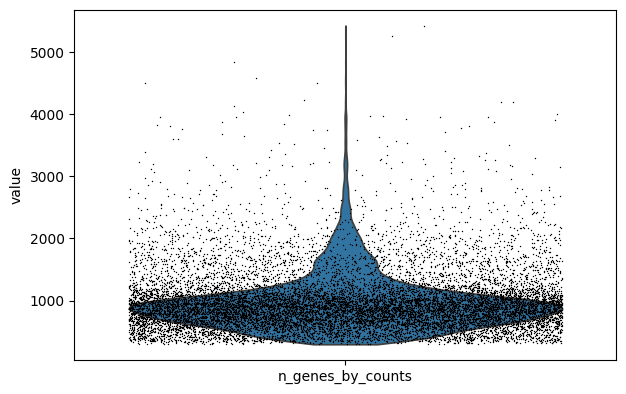

In [15]:
#Average number of genes with at least one detected identifier in each cell
sc.pl.violin(
    b_marrow_adata,
    ["n_genes_by_counts"],
    jitter=0.4,
    multi_panel=False,
)

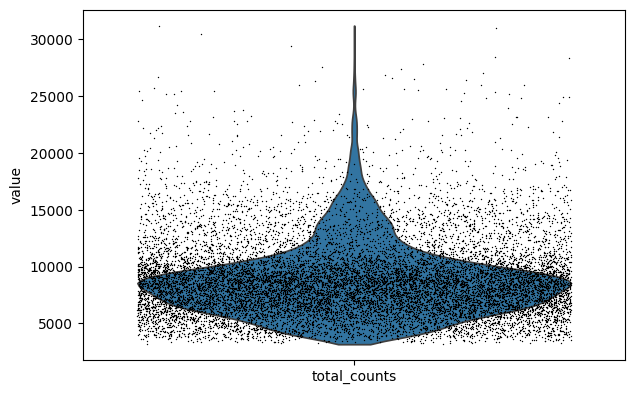

In [16]:
#Total number of molecules (UMI) detected in cell.
sc.pl.violin(
    b_marrow_adata,
    ["total_counts"],
    jitter=0.4,
    multi_panel=False,
)

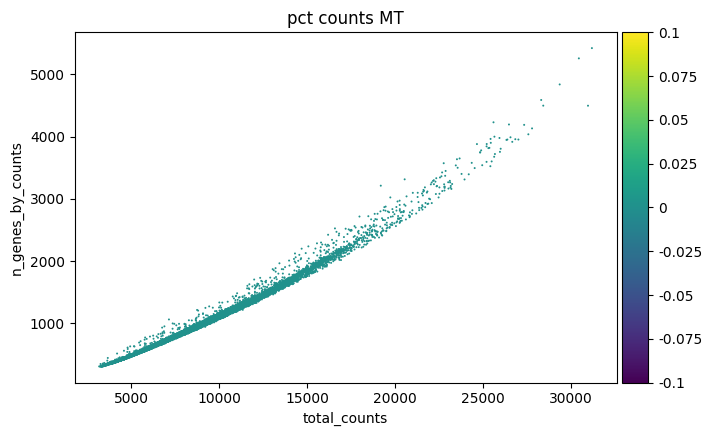

In [17]:
#Visualization of mt genes
sc.pl.scatter(b_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_MT")

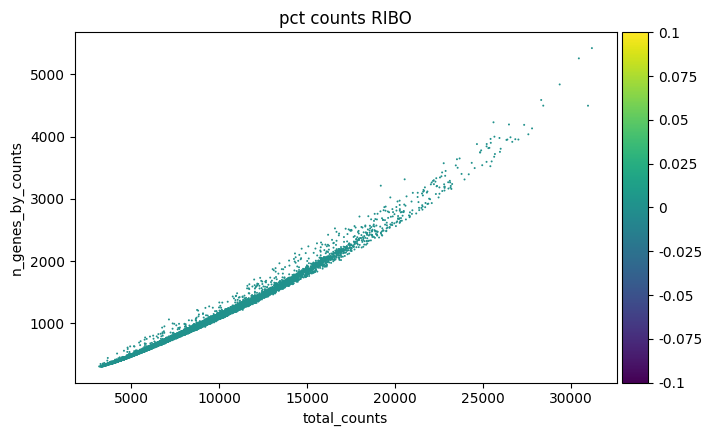

In [18]:
#visualization of ribosomal genes
sc.pl.scatter(b_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_RIBO")

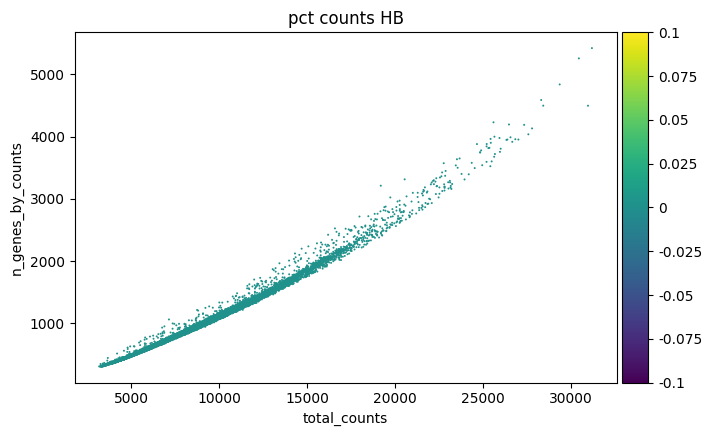

In [19]:
#Visualization of HB genes
sc.pl.scatter(b_marrow_adata, "total_counts", "n_genes_by_counts", color="pct_counts_HB")

In [20]:
b_marrow_adata.obs.columns

Index(['disease stage', 'treatment', 'timepoint', 'Dataset', 'sample',
       'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage',
       'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts',
       'percent_mito', 'tissue_original', 'tissue_ontology_term_id',
       'disease_ontology_term_id', 'donor_id',
       'development_stage_ontology_term_id', 'assay_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id',
       'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease',
       'sex', 'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 't

## 4. Doublet detection with Scrublet
Why: identify droplets that likely contain more than one cell and could create artifactual clusters.


In [21]:
#--- 3. Doublet detection with Scrublet on raw counts
!pip install scrublet

import scrublet as scr
import scipy.sparse as sp

sc.pp.scrublet(b_marrow_adata)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.5/647.5 kB 25.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for annoy: filename=annoy-1.17.3-cp312-cp312-linux_x86_64.whl size=551804 sha256=6197c4b9e2582b09b48f0eb9df8c0b72b2e8cc3ec2f6dc693adeafacc4433666
  Stored in directory: /root/.cache/pip/wheels/db/b9/53/a3b2d1fe1743abadddec6aa541294b24fdbc39d7800bc57311
Successfully built annoy


In [22]:
# ---------- Scrublet doublet detection ----------

# Use raw counts
if "counts" in b_marrow_adata.layers:
    counts_matrix = b_marrow_adata.layers["counts"]
else:
    counts_matrix = b_marrow_adata.X

# Convert to dense scrublet
if sp.issparse(counts_matrix):
    counts_matrix = counts_matrix.toarray()

#Initialize Scrublet with a reasonable expected doublet rate (~5-10%)
scrub = scr.Scrublet(
    counts_matrix,
    expected_doublet_rate=0.06  # 6% prior; fine for coursework unless told otherwise
)

# Compute pre-cell doublet scores and binary calls
doublet_scores, predicted_doublets = scrub.scrub_doublets()

# Store outputs in pre-cell metadata
b_marrow_adata.obs["doublet_score"] = doublet_scores
b_marrow_adata.obs["predicted_doublet"] = predicted_doublets

# Sanity check
b_marrow_adata.obs[["doublet_score", "predicted_doublet"]].head()


Preprocessing...


/usr/local/lib/python3.12/dist-packages/scrublet/helper_functions.py:239: RuntimeWarning: invalid value encountered in log
  gLog = lambda input: np.log(input[1] * np.exp(-input[0]) + input[2])
/usr/local/lib/python3.12/dist-packages/scrublet/helper_functions.py:252: RuntimeWarning: invalid value encountered in sqrt
  CV_input = np.sqrt(b);


Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.70
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 9.5%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 0.6%
Elapsed time: 71.7 seconds


doublet_score  predicted_doublet
index                                                   
Guo-AAACCTGAGAGCTTCT-2       0.016600              False
Guo-AAACCTGAGAGGTTGC-7       0.028139              False
Guo-AAACCTGAGATACACA-3       0.124144              False
Guo-AAACCTGAGCGATTCT-1       0.042846              False
Guo-AAACCTGAGTGAAGAG-3       0.044715              False

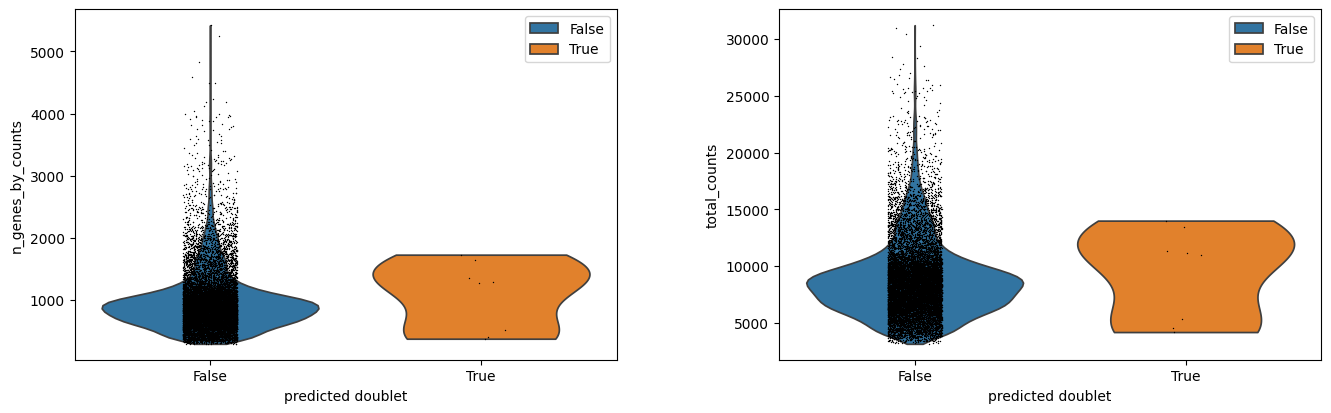

In [23]:
# Compare QC metrics between singlets and predicted doublets
b_marrow_adata.obs['predicted_doublet'] = b_marrow_adata.obs['predicted_doublet'].astype('category')
sc.pl.violin(
    b_marrow_adata,
    ["n_genes_by_counts", "total_counts"],
    groupby="predicted_doublet",
    multi_panel=True
)

In [24]:
# ---------- Filter out predicted doublets ----------

before = b_marrow_adata.n_obs
b_marrow_adata = b_marrow_adata[b_marrow_adata.obs["predicted_doublet"] == False].copy()
after = b_marrow_adata.n_obs

print(f"Removed {before - after} predicted doublets; remaining {after} cells.")

Removed 8 predicted doublets; remaining 14775 cells.


In [ ]:
# Compare QC metrics between singlets and predicted doublets
b_marrow_adata.obs['predicted_doublet'] = b_marrow_adata.obs['predicted_doublet'].astype('category')
sc.pl.violin(
    b_marrow_adata,
    ["n_genes_by_counts", "total_counts"],
    groupby="predicted_doublet",
    multi_panel=True
)

## 5. Normalization, log-transform and highly variable genes
Why: stabilize variance and focus on informative genes for downstream dimensionality reduction.

In [25]:
#Save a copy of the bone marrow data
b_marrow_adata.layers["counts"] = b_marrow_adata.X.copy()

In [26]:
#Normalizing to median total counts
sc.pp.normalize_total(b_marrow_adata)
#Log of the data
sc.pp.log1p(b_marrow_adata)

In [27]:
#Selecting top 1000 most variable genes
sc.pp.highly_variable_genes(b_marrow_adata, n_top_genes=1000)

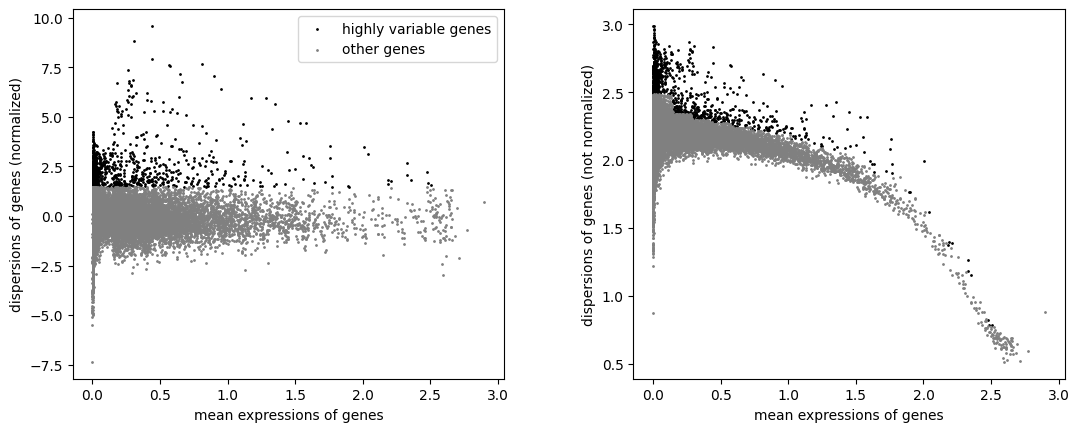

In [28]:
sc.pl.highly_variable_genes(b_marrow_adata)

## 6. PCA, neighborhood graph, UMAP and Leiden clustering
Why: embed cells into a low-dimensional manifold and identify transcriptionally similar groups.

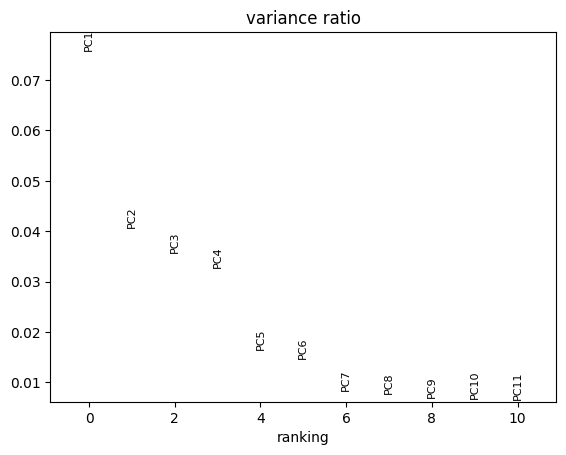

In [29]:
sc.tl.pca(b_marrow_adata)
sc.pl.pca_variance_ratio(b_marrow_adata, n_pcs=10, log=False)

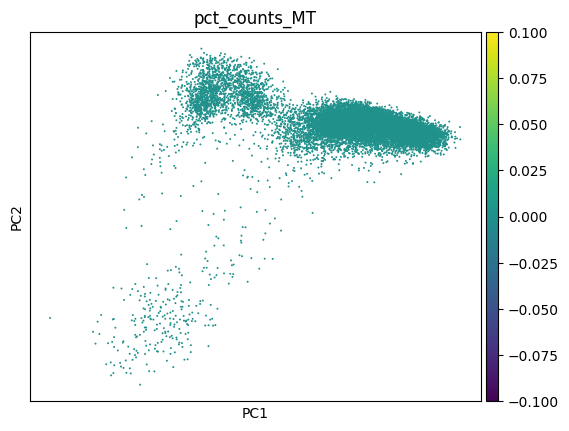

In [30]:
sc.pl.pca(
    b_marrow_adata,
    color=["pct_counts_MT"]
)

In [31]:
sc.pp.neighbors(b_marrow_adata)
sc.tl.umap(b_marrow_adata)

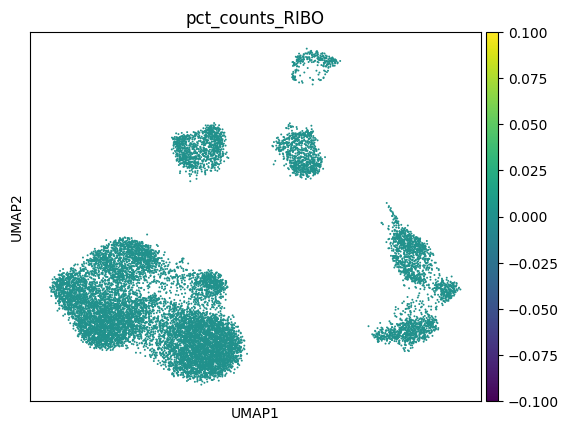

In [32]:
sc.pl.umap(
    b_marrow_adata,
    color=["pct_counts_RIBO"],
    size=8,
)

In [33]:
sc.tl.leiden(b_marrow_adata, flavor="igraph", n_iterations=2)

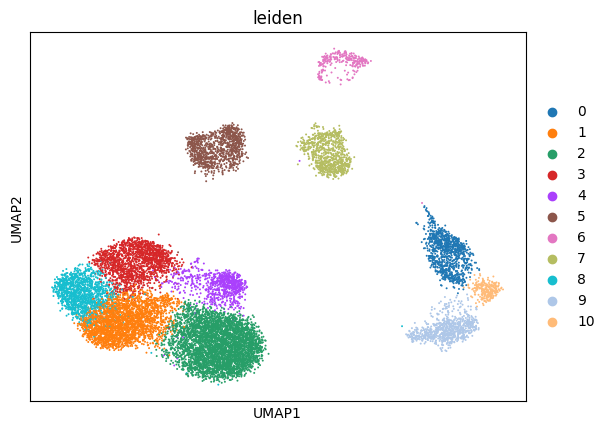

In [34]:
sc.pl.umap(
    b_marrow_adata,
    color=["leiden"],
    size=8,
)

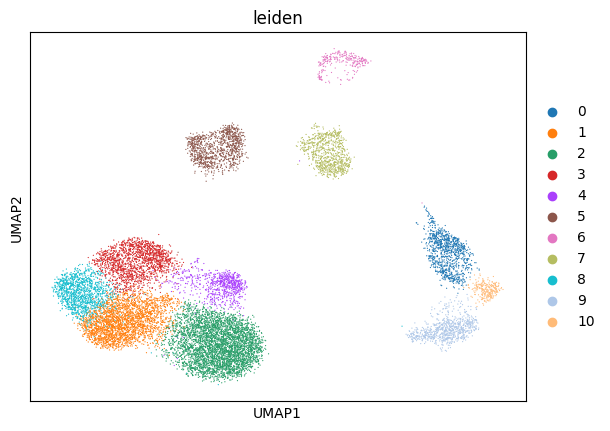

In [35]:
sc.pl.umap(
    b_marrow_adata,
    color=["leiden"],
    wspace=0.5,
    size=3,
    ncols = 1
)

In [36]:
b_marrow_adata.obs.columns

Index(['disease stage', 'treatment', 'timepoint', 'Dataset', 'sample',
       'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage',
       'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts',
       'percent_mito', 'tissue_original', 'tissue_ontology_term_id',
       'disease_ontology_term_id', 'donor_id',
       'development_stage_ontology_term_id', 'assay_ontology_term_id',
       'cell_type_ontology_term_id',
       'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id',
       'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease',
       'sex', 'tissue', 'self_reported_ethnicity', 'development_stage',
       'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts',
       'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes',
       'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes',
       'pct_counts_in_top_500_genes', 'total_counts_MT',
       'log1p_total_counts_MT', 'pct_counts_MT', 't

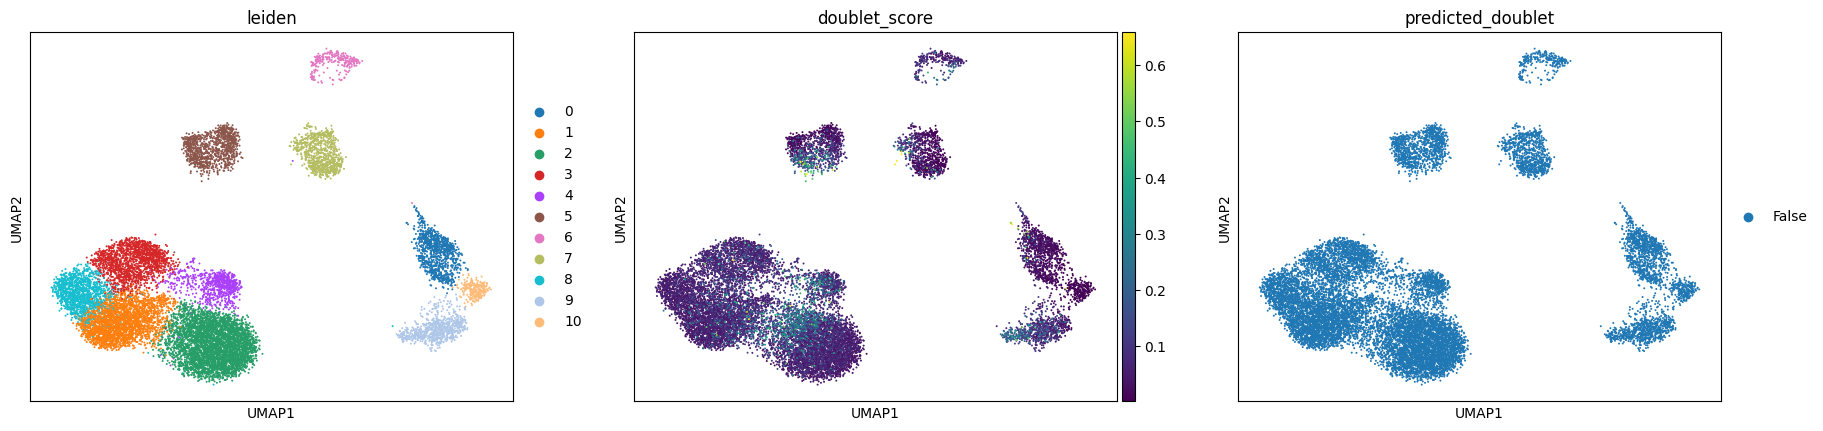

In [40]:
sc.pl.umap(b_marrow_adata, color=["leiden", "doublet_score", "predicted_doublet"])

In [39]:
sc.tl.leiden(b_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_02", resolution=0.02)
sc.tl.leiden(b_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res0_5", resolution=0.5)
sc.tl.leiden(b_marrow_adata, flavor="igraph", n_iterations=2, key_added="leiden_res2", resolution=2)

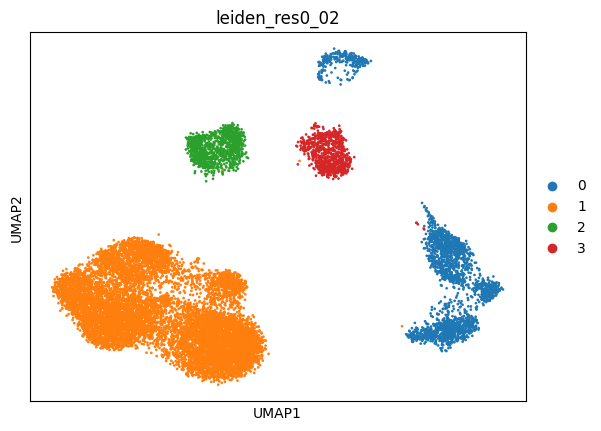

In [41]:
sc.pl.umap(
    b_marrow_adata,
    color=["leiden_res0_02"],
    # increase horizontal space between panels
    wspace=0.5,
    size=15,
    ncols = 1
)

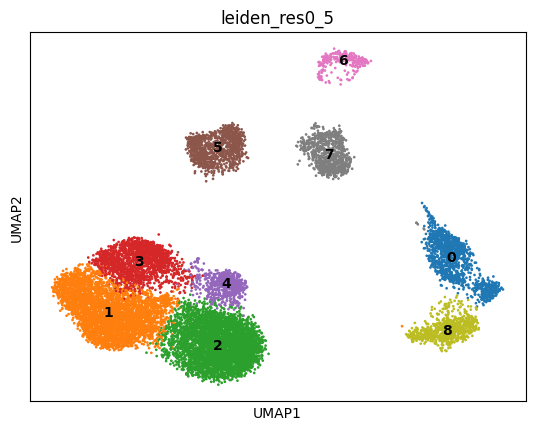

In [42]:
sc.pl.umap(
    b_marrow_adata,
    color=["leiden_res0_5"],
    wspace=0.5,
    size=15,
    ncols = 1,
    legend_loc="on data"
)

In [ ]:
sc.pl.umap(
    b_marrow_adata,
    color=["leiden_res2"],
    wspace=0.5,
    size=15,
    ncols = 1,
    legend_loc="on data"
)

## 7. Cell-type scoring with decoupler (PanglaoDB)
Why: use reference marker signatures to quantify how “neutrophil-like”, “B cell-like”, etc. each cell is.

In [43]:
import decoupler as dc

In [44]:
# Query Omnipath and get CellMarker
markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format because dc only accepts cell_type and genesymbol

markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]


markers.tail()

source   target
                                     
8201           B cells naive  ZNF286A
8202  Pluripotent stem cells   ZNF296
8203              Adipocytes   ZNF423
8205        Gamma (PP) cells   ZNF503
8208              Germ cells    ZPBP2

In [45]:
# This line was causing an error and is not a valid operation for a pandas DataFrame.
# If you intended to remove the 'markers' variable from memory, you could use 'del markers'.
# markers.free()

In [46]:
import pandas as pd
import decoupler as dc

# Query Omnipath and get CellMarker
markers = dc.op.resource(name="PanglaoDB", organism="human")

# Keep canonical cell type markers alone
markers = markers[markers["canonical_marker"]]

# Remove duplicated entries
markers = markers[~markers.duplicated(["cell_type", "genesymbol"])]

# Format because dc only accepts cell_type and genesymbol
markers = markers.rename(columns={"cell_type": "source", "genesymbol": "target"})
markers = markers[["source", "target"]]

# Convert 'feature_name' column to a plain Index of strings before assigning to var_names
b_marrow_adata.var_names = pd.Index(b_marrow_adata.var['feature_name'].astype(str))
b_marrow_adata.var_names_make_unique()

dc.mt.ulm(data=b_marrow_adata,
          net=markers,
          tmin = 3)

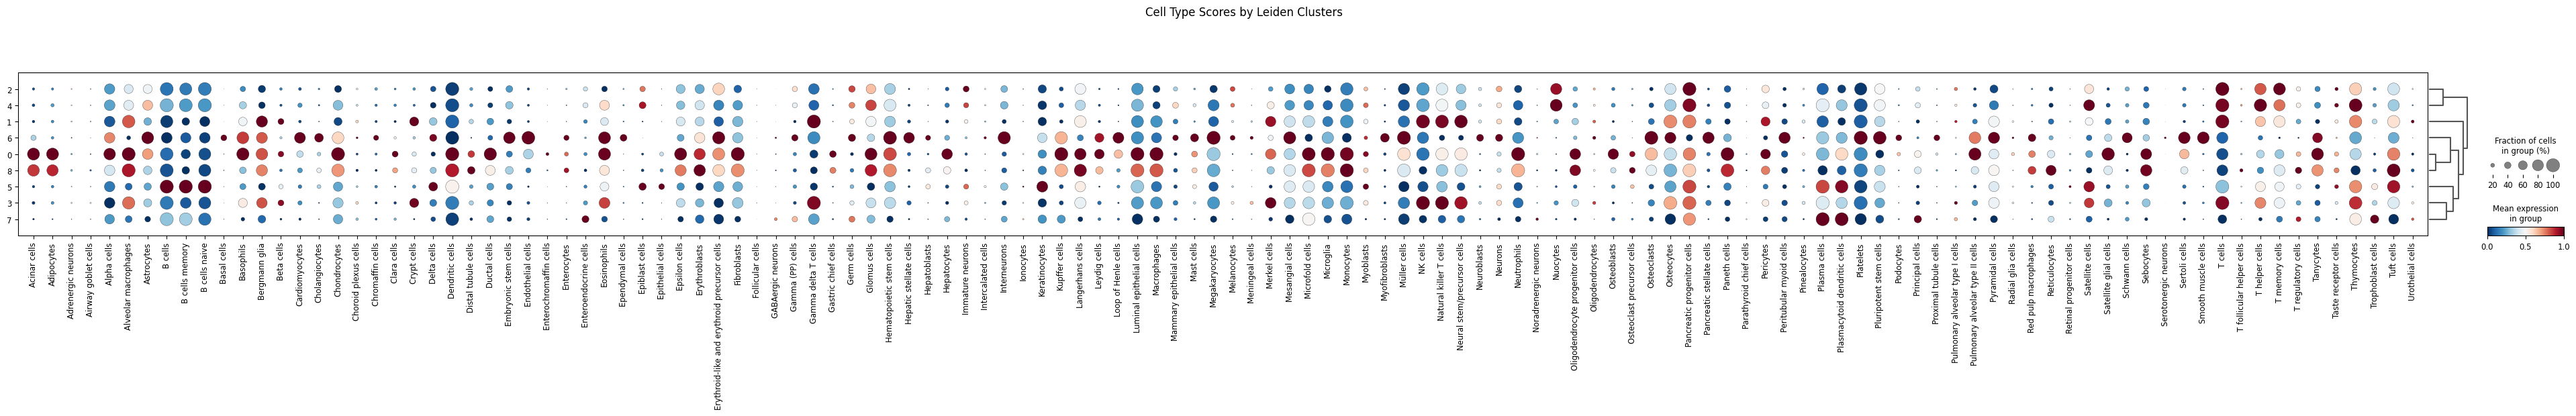

In [47]:
import pandas as pd
import decoupler as dc

# retrieve the score for each cell type
score = dc.pp.get_obsm(b_marrow_adata, key="score_ulm")

sc.pl.dotplot(
    score, # Use the 'score' AnnData object directly
    var_names=score.var_names.tolist(), # List of cell types (features)
    groupby='leiden_res0_5',
    cmap='RdBu_r', # A common colormap for scores
    dendrogram=True,
    standard_scale='var', # Scale scores for better visualization
    title='Cell Type Scores by Leiden Clusters'
)

In [48]:
#retrieve the score for each cell type

score = dc.pp.get_obsm(b_marrow_adata, key="score_ulm")
score

AnnData object with n_obs × n_vars = 14775 × 126
    obs: 'disease stage', 'treatment', 'timepoint', 'Dataset', 'sample', 'disease_original', 'disease_general', 'COVID-19 Condition', 'Lineage', 'Cell.group', 'Cell.class_reannotated', 'n_genes', 'n_counts', 'percent_mito', 'tissue_original', 'tissue_ontology_term_id', 'disease_ontology_term_id', 'donor_id', 'development_stage_ontology_term_id', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'is_primary_data', 'suspension_type', 'tissue_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_MT', 'log1p_total_counts_MT', 'pct_counts_MT', 'total_counts_RIBO', 'log1p_total_counts_RIBO', '

In [49]:
#preview the data
b_marrow_adata.obsm["score_ulm"].head()

Acinar cells  Adipocytes  Adrenergic neurons  \
index                                                                  
Guo-AAACCTGAGAGCTTCT-2      0.883196    0.016172           -0.592763   
Guo-AAACCTGAGAGGTTGC-7     -0.906472   -1.284357           -0.467944   
Guo-AAACCTGAGATACACA-3     -0.892511   -0.682595           -0.460737   
Guo-AAACCTGAGCGATTCT-1     -0.922332   -0.772991           -0.476131   
Guo-AAACCTGAGTGAAGAG-3     -0.643714   -0.510408           -0.332304   

                        Airway goblet cells  Alpha cells  \
index                                                      
Guo-AAACCTGAGAGCTTCT-2            -0.662750     0.835667   
Guo-AAACCTGAGAGGTTGC-7            -0.523193     1.582970   
Guo-AAACCTGAGATACACA-3            -0.515135     1.573108   
Guo-AAACCTGAGCGATTCT-1            -0.532347     0.269734   
Guo-AAACCTGAGTGAAGAG-3            -0.371538    -0.621868   

                        Alveolar macrophages  Astrocytes   B cells  \
index                                                                
Guo-AAACCTGAGAGCTTCT-2              0.855610    0.297362  1.485401   
Guo-AAACCTGAGAGGTTGC-7              1.219200    0.157597  0.487638   
Guo-AAACCTGAGATACACA-3              1.187771    1.655806  3.930386   
Guo-AAACCTGAGCGATTCT-1              1.180720    0.774227  4.511881   
Guo-AAACCTGAGTGAAGAG-3              1.977566    0.019228  1.642715   

                        B cells memory  B cells naive  ...  \
index                                                  ...   
Guo-AAACCTGAGAGCTTCT-2       -0.306813       0.237723  ...   
Guo-AAACCTGAGAGGTTGC-7       -0.624590       1.769927  ...   
Guo-AAACCTGAGATACACA-3        1.925690       2.499721  ...   
Guo-AAACCTGAGCGATTCT-1        1.123622       1.731358  ...   
Guo-AAACCTGAGTGAAGAG-3        2.015970       2.029781  ...   

                        T follicular helper cells  T helper cells  \
index                                                               
Guo-AAACCTGAGAGCTTCT-2                  -0.513332       -0.423010   
Guo-AAACCTGAGAGGTTGC-7                  -0.405239        3.167798   
Guo-AAACCTGAGATACACA-3                  -0.398998        1.170178   
Guo-AAACCTGAGCGATTCT-1                  -0.412329        0.080981   
Guo-AAACCTGAGTGAAGAG-3                  -0.287775        2.170267   

                        T memory cells  T regulatory cells  Tanycytes  \
index                                                                   
Guo-AAACCTGAGAGCTTCT-2        1.642708           -0.004526   0.544176   
Guo-AAACCTGAGAGGTTGC-7       -0.405239            0.462814   0.897703   
Guo-AAACCTGAGATACACA-3        2.442434           -0.798214   0.924881   
Guo-AAACCTGAGCGATTCT-1        2.299869           -0.824884  -0.673433   
Guo-AAACCTGAGTGAAGAG-3        3.344261            1.184725  -0.470005   

                        Taste receptor cells  Thymocytes  Trophoblast cells  \
index                                                                         
Guo-AAACCTGAGAGCTTCT-2              0.413650   -0.543568          -0.513332   
Guo-AAACCTGAGAGGTTGC-7              0.897703    3.847757          -0.405239   
Guo-AAACCTGAGATACACA-3             -0.651660    1.906148           2.286254   
Guo-AAACCTGAGCGATTCT-1             -0.673433    0.929613          -0.412329   
Guo-AAACCTGAGTGAAGAG-3             -0.470005   -0.761787          -0.287775   

                        Tuft cells  Urothelial cells  
index                                                 
Guo-AAACCTGAGAGCTTCT-2    3.113609         -0.784226  
Guo-AAACCTGAGAGGTTGC-7   -0.202540         -0.619087  
Guo-AAACCTGAGATACACA-3    0.851432         -0.609553  
Guo-AAACCTGAGCGATTCT-1    1.709262         -0.629920  
Guo-AAACCTGAGTGAAGAG-3    1.786946         -0.439636  

[5 rows x 126 columns]

In [50]:
b_marrow_adata.obsm["score_ulm"].columns

Index(['Acinar cells', 'Adipocytes', 'Adrenergic neurons',
       'Airway goblet cells', 'Alpha cells', 'Alveolar macrophages',
       'Astrocytes', 'B cells', 'B cells memory', 'B cells naive',
       ...
       'T follicular helper cells', 'T helper cells', 'T memory cells',
       'T regulatory cells', 'Tanycytes', 'Taste receptor cells', 'Thymocytes',
       'Trophoblast cells', 'Tuft cells', 'Urothelial cells'],
      dtype='object', length=126)

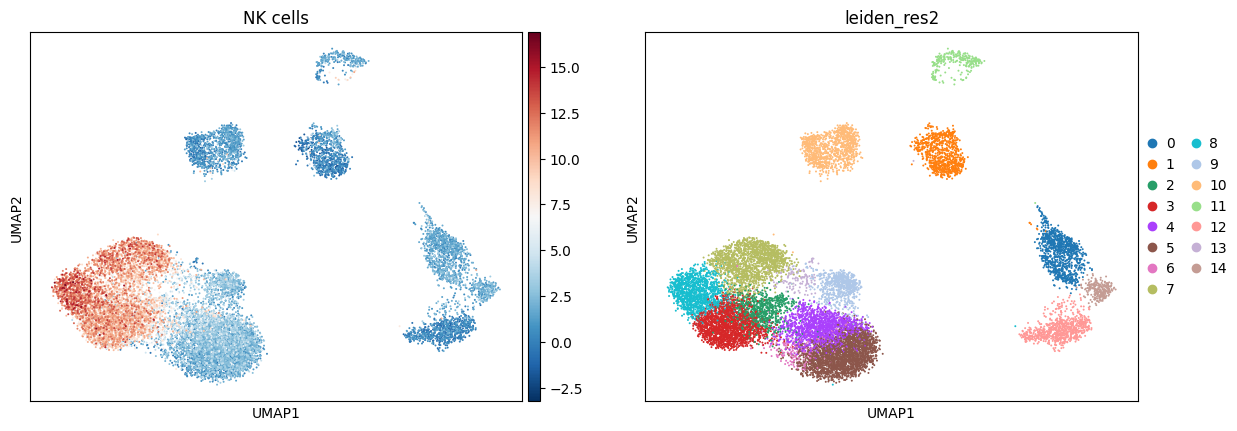

In [51]:
sc.pl.umap(score, color=["NK cells", "leiden_res2"], cmap="RdBu_r")

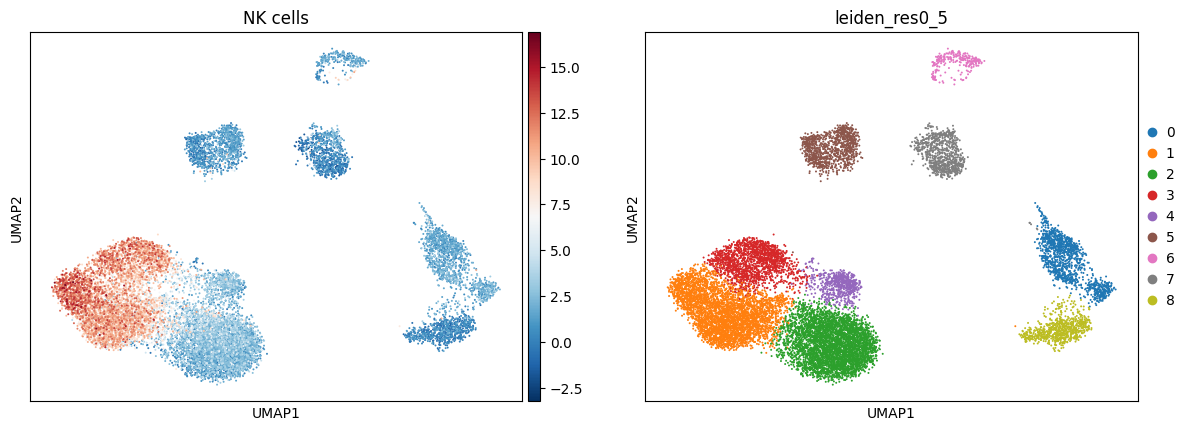

In [52]:
sc.pl.umap(score, color=["NK cells", "leiden_res0_5"], cmap="RdBu_r")

## 8. Cluster annotation and visualization
Why: assign human-readable cell-type labels to clusters and interpret the cellular composition.

In [53]:
# Get cell-type scores as DataFrame
score = dc.pp.get_obsm(b_marrow_adata, key="score_ulm")

#Rank signatures per cluster for your main clustering
rank_df = dc.tl.rankby_group(
    score,
    groupby="leiden_res2",  # use the same clustering
    reference="rest",
    method="t-test_overestim_var",
)

# Keep only positive stats (enriched vs rest)
rank_df = rank_df[rank_df["stat"] > 0]

#Take top signature per cluster
cluster_auto = (
    rank_df
    .sort_values(["group", "stat"], ascending=[True, False])
    .groupby("group")
    .head(1)
    .set_index("group")["name"]   # 'name' = signature (e.g. "Neutrophils")
    .to_dict()
)

cluster_auto

/tmp/ipython-input-236540010.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")


{'0': 'Neutrophils',
 '1': 'Plasma cells',
 '10': 'B cells naive',
 '11': 'Platelets',
 '12': 'Monocytes',
 '13': 'Thymocytes',
 '14': 'Neutrophils',
 '2': 'Gamma delta T cells',
 '3': 'NK cells',
 '4': 'Nuocytes',
 '5': 'Nuocytes',
 '6': 'Nuocytes',
 '7': 'NK cells',
 '8': 'Gamma delta T cells',
 '9': 'Nuocytes'}

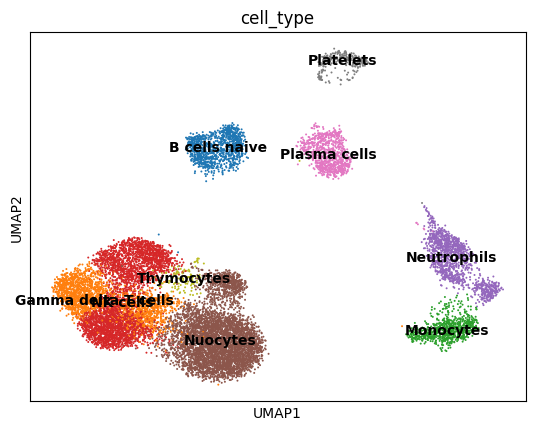

In [54]:
b_marrow_adata.obs["cell_type"] = (
    b_marrow_adata.obs["leiden_res2"].map(cluster_auto)
).astype("category")

sc.pl.umap(b_marrow_adata, color=["cell_type"], legend_loc="on data")

In [55]:
# 1. Get cell-type scores as DataFrame
score = dc.pp.get_obsm(b_marrow_adata, key="score_ulm")

# 2. Rank signatures per cluster for your main clustering
rank_df = dc.tl.rankby_group(
    score,
    groupby="leiden_res0_02",  # use the same clustering
    reference="rest",
    method="t-test_overestim_var",
)

# Keep only positive stats (enriched vs rest)
rank_df = rank_df[rank_df["stat"] > 0]

# 3. Take top signature per cluster
cluster_auto = (
    rank_df
    .sort_values(["group", "stat"], ascending=[True, False])
    .groupby("group")
    .head(1)
    .set_index("group")["name"]   # 'name' = signature (e.g. "Neutrophils")
    .to_dict()
)

cluster_auto

/tmp/ipython-input-1142291015.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")


{'0': 'Neutrophils', '1': 'T cells', '2': 'B cells naive', '3': 'Plasma cells'}

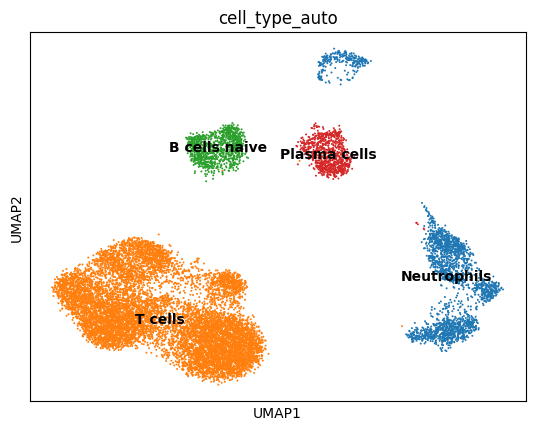

In [56]:
b_marrow_adata.obs["cell_type_auto"] = (
    b_marrow_adata.obs["leiden_res0_02"].map(cluster_auto)
).astype("category")

sc.pl.umap(b_marrow_adata, color=["cell_type_auto"], legend_loc="on data")

In [57]:
# Get cell-type scores as DataFrame
score = dc.pp.get_obsm(b_marrow_adata, key="score_ulm")

# 2. Rank signatures per cluster for your main clustering
rank_df = dc.tl.rankby_group(
    score,
    groupby="leiden_res0_5",  # use the same clustering
    reference="rest",
    method="t-test_overestim_var",
)

# Keep only positive stats (enriched vs rest)
rank_df = rank_df[rank_df["stat"] > 0]

# Take top signature per cluster
cluster_auto = (
    rank_df
    .sort_values(["group", "stat"], ascending=[True, False])
    .groupby("group")
    .head(1)
    .set_index("group")["name"]   # 'name' = signature (e.g. "Neutrophils")
    .to_dict()
)

cluster_auto

/tmp/ipython-input-213670575.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("group")


{'0': 'Neutrophils',
 '1': 'Gamma delta T cells',
 '2': 'Nuocytes',
 '3': 'NK cells',
 '4': 'Nuocytes',
 '5': 'B cells naive',
 '6': 'Platelets',
 '7': 'Plasma cells',
 '8': 'Monocytes'}

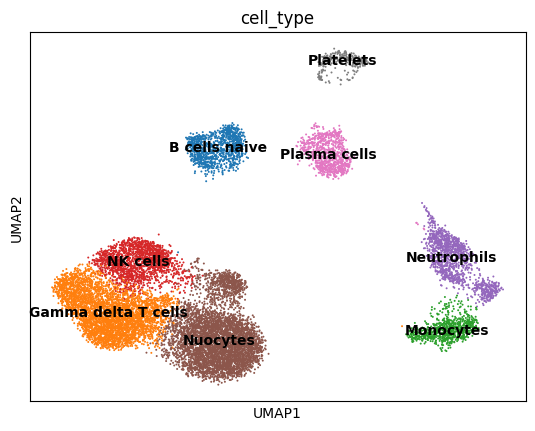

In [84]:
b_marrow_adata.obs["cell_type"] = (
    b_marrow_adata.obs["leiden_res0_5"].map(cluster_auto)
).astype("category")

sc.pl.umap(b_marrow_adata, color=["cell_type"], legend_loc="on data")

In [59]:
import seaborn as sns

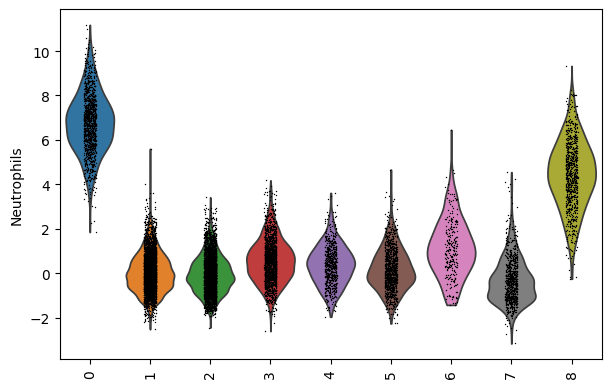

In [60]:
sc.pl.violin(score, keys=["Neutrophils"], groupby="leiden_res0_5", rotation=90)

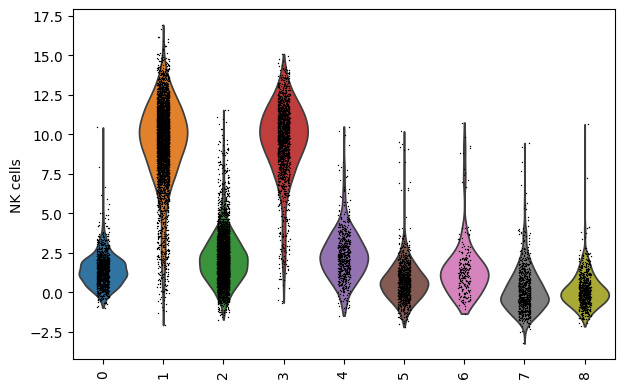

In [61]:
sc.pl.violin(score, keys=["NK cells"], groupby="leiden_res0_5", rotation=90)

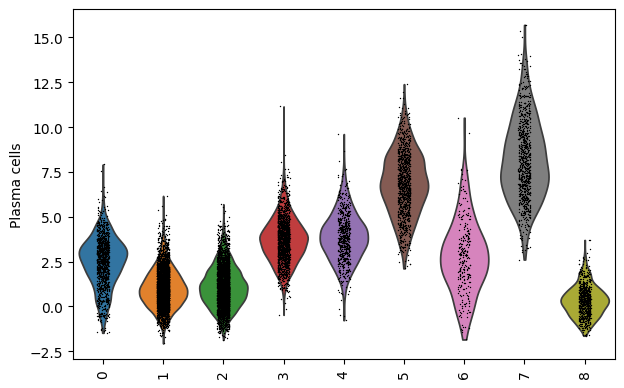

In [62]:
sc.pl.violin(score, keys=["Plasma cells"], groupby="leiden_res0_5", rotation=90)

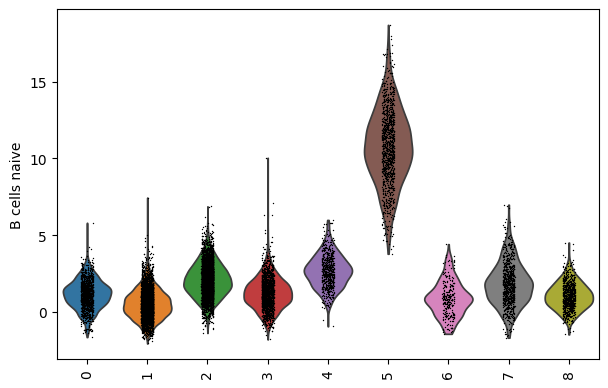

In [63]:
sc.pl.violin(score, keys=["B cells naive"], groupby="leiden_res0_5", rotation=90)

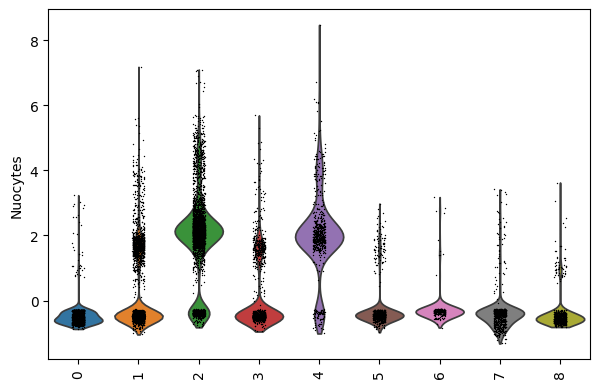

In [64]:
sc.pl.violin(score, keys=["Nuocytes"], groupby="leiden_res0_5", rotation=90)

In [65]:
#rank genes
b_marrow_adata_rank = dc.tl.rankby_group(score, groupby="leiden_res0_02", reference="rest", method="t-test_overestim_var")
b_marrow_adata_rank = b_marrow_adata_rank[b_marrow_adata_rank["stat"] > 0]

In [66]:
#rank genes
b_marrow_adata_rank = dc.tl.rankby_group(score, groupby="leiden_res0_5", reference="rest", method="t-test_overestim_var")
b_marrow_adata_rank = b_marrow_adata_rank[b_marrow_adata_rank["stat"] > 0]
b_marrow_adata_rank.head()

group reference             name        stat  meanchange  pval  padj
0     0      rest      Neutrophils  114.341850    6.388398   0.0   0.0
1     0      rest      Macrophages   88.427998    5.631323   0.0   0.0
2     0      rest  Dendritic cells   84.662203    5.374353   0.0   0.0
3     0      rest        Microglia   83.738661    4.275681   0.0   0.0
4     0      rest        Monocytes   80.326601    5.562833   0.0   0.0

In [67]:
#rank genes
b_marrow_adata_rank = dc.tl.rankby_group(score, groupby="leiden_res2", reference="rest", method="t-test_overestim_var")
b_marrow_adata_rank = b_marrow_adata_rank[b_marrow_adata_rank["stat"] > 0]
b_marrow_adata_rank.head()

group reference             name       stat  meanchange  pval  padj
0     0      rest      Neutrophils  94.145477    6.340401   0.0   0.0
1     0      rest      Macrophages  82.164788    5.886494   0.0   0.0
2     0      rest        Monocytes  74.261288    5.749083   0.0   0.0
3     0      rest  Dendritic cells  72.260600    5.285501   0.0   0.0
4     0      rest        Microglia  69.842057    4.153980   0.0   0.0

In [68]:
cluster_annotations = b_marrow_adata_rank[b_marrow_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()

/tmp/ipython-input-1605432823.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_annotations = b_marrow_adata_rank[b_marrow_adata_rank["stat"] > 0].groupby("group").head(1).set_index("group")["name"].to_dict()


In [69]:
cluster_annotations

{'0': 'Neutrophils',
 '2': 'Gamma delta T cells',
 '4': 'Nuocytes',
 '7': 'NK cells',
 '9': 'Nuocytes',
 '10': 'B cells naive',
 '11': 'Platelets',
 '5': 'Nuocytes',
 '1': 'Plasma cells',
 '3': 'NK cells',
 '8': 'Gamma delta T cells',
 '12': 'Monocytes',
 '13': 'Thymocytes',
 '6': 'Nuocytes',
 '14': 'Neutrophils'}

In [70]:
b_marrow_adata.obs['cell_type'] = b_marrow_adata.obs['leiden_res0_02'].map(cluster_annotations)


In [71]:
b_marrow_adata.obs['cell_type'] = b_marrow_adata.obs['leiden_res0_5'].map(cluster_annotations)

In [72]:
b_marrow_adata.obs['cell_type'] = b_marrow_adata.obs['leiden_res2'].map(cluster_annotations)

In [73]:
# Example of how to subset for multiple genes in the 'source' column
available_genes = set(b_marrow_adata.var_names)

neutro_markers = markers[markers['source'].isin(['Neutrophils'])]['target']
neutro_markers = neutro_markers[neutro_markers.isin(available_genes)]

macro_markers = markers[markers['source'].isin(['Macrophages'])]['target']
macro_markers = macro_markers[macro_markers.isin(available_genes)]

den_cells_markers = markers[markers['source'].isin(['Dendritic cells'])]['target']
den_cells_markers = den_cells_markers[den_cells_markers.isin(available_genes)]

kup_cells_markers = markers[markers['source'].isin(['Kupffer cells'])]['target']
kup_cells_markers = kup_cells_markers[kup_cells_markers.isin(available_genes)]

micro_markers = markers[markers['source'].isin(['Microglia'])]['target']
micro_markers = micro_markers[micro_markers.isin(available_genes)]

In [74]:
marker_genes_dict = {
    "Neutrophils":neutro_markers.head().tolist(),
    "Macrrophages": macro_markers.head().tolist(),
    "Dendritic cells": den_cells_markers.head().tolist(),
     "Kupffer cells": kup_cells_markers.head().tolist(),
     "Microglia": micro_markers.head().tolist()
}

In [75]:
sc.tl.dendrogram

<function scanpy.tools._dendrogram.dendrogram(adata: 'AnnData', groupby: 'str | Sequence[str]', *, n_pcs: 'int | None' = None, use_rep: 'str | None' = None, var_names: 'Sequence[str] | None' = None, use_raw: 'bool | None' = None, cor_method: 'str' = 'pearson', linkage_method: 'str' = 'complete', optimal_ordering: 'bool' = False, key_added: 'str | None' = None, inplace: 'bool' = True) -> 'dict[str, Any] | None'>

categories: 0, 1, 2, etc.
var_group_labels: Neutrophils, Macrrophages, Dendritic cells, etc.


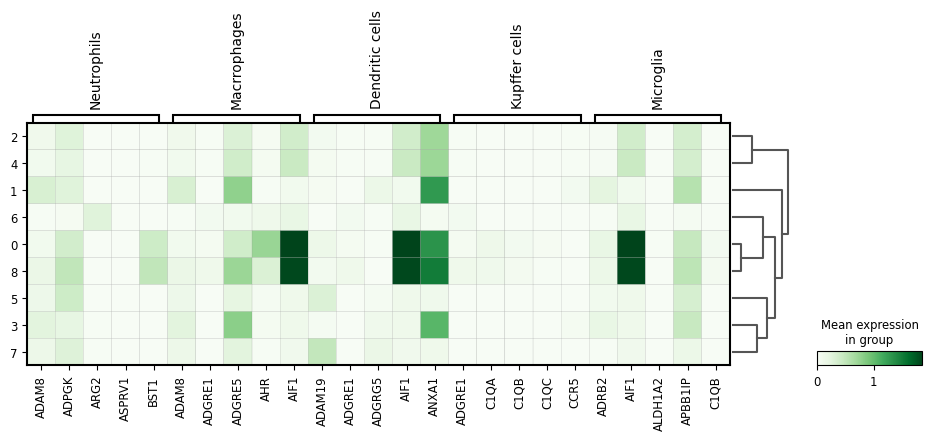

In [76]:
sc.tl.dendrogram(b_marrow_adata, groupby="leiden_res0_5")
sc.pl.matrixplot(
    b_marrow_adata,
    marker_genes_dict,
    "leiden_res0_5",
    dendrogram=True,
    cmap="Greens",
    use_raw=False
)

categories: 0, 1, 2, etc.
var_group_labels: Neutrophils, Macrrophages, Dendritic cells, etc.


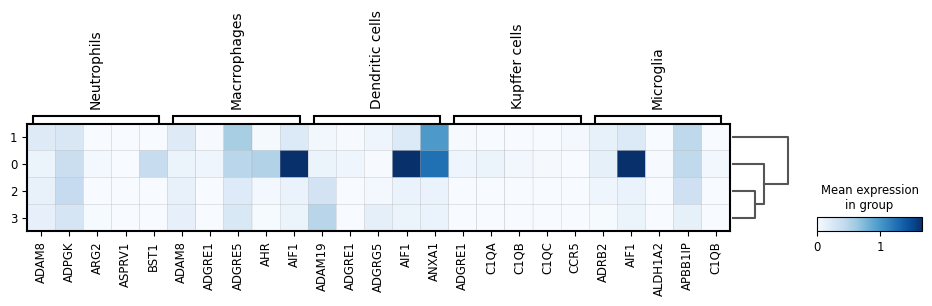

In [77]:
sc.tl.dendrogram(b_marrow_adata, groupby="leiden_res0_02")
sc.pl.matrixplot(
    b_marrow_adata,
    marker_genes_dict,
    "leiden_res0_02",
    dendrogram=True,
    cmap="Blues",
    use_raw=False
)

categories: 0, 1, 2, etc.
var_group_labels: Neutrophils, Macrrophages, Dendritic cells, etc.


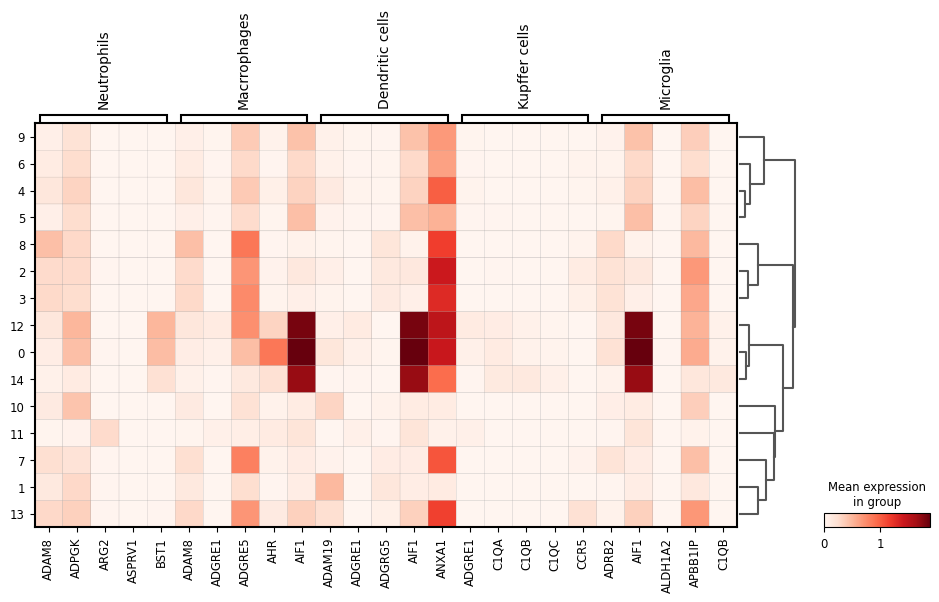

In [78]:
sc.tl.dendrogram(b_marrow_adata, groupby="leiden_res2")
sc.pl.matrixplot(
    b_marrow_adata,
    marker_genes_dict,
    "leiden_res2",
    dendrogram=True,
    cmap="Reds",
    use_raw=False
)

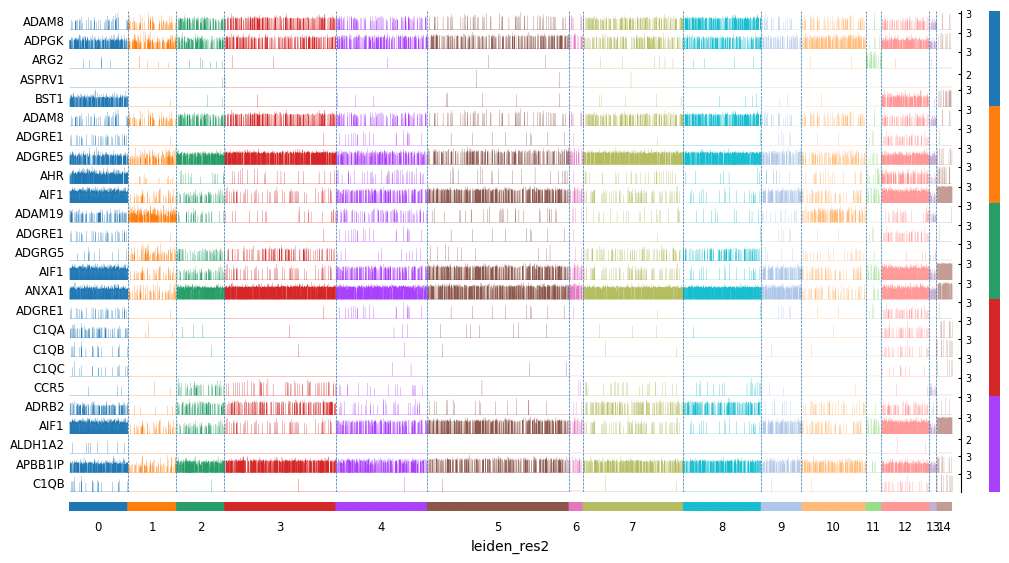

In [79]:
sc.pl.tracksplot(b_marrow_adata, marker_genes_dict, groupby="leiden_res2", dendrogram=False, use_raw=False)

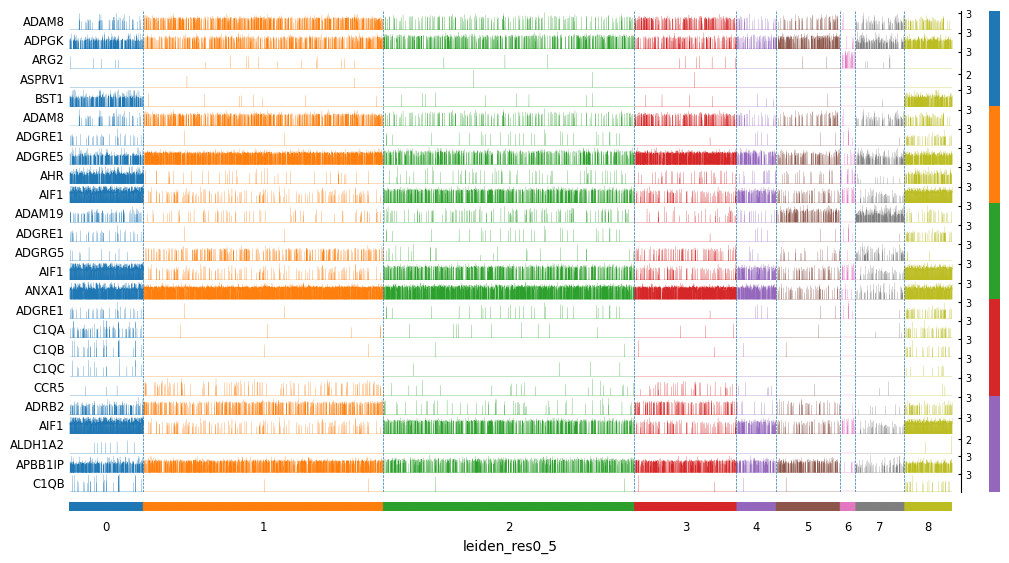

In [80]:
b_marrow_adata.var.index = b_marrow_adata.var.index.astype(str)
b_marrow_adata.var_names_make_unique()
sc.pl.tracksplot(b_marrow_adata, marker_genes_dict, groupby="leiden_res0_5", dendrogram=False, use_raw=False)

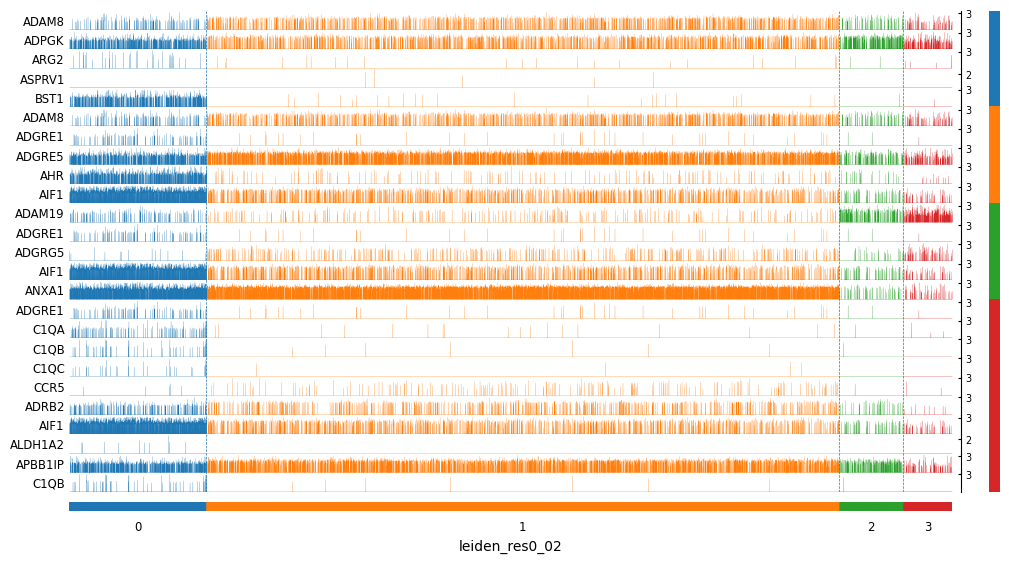

In [81]:
b_marrow_adata.var.index = b_marrow_adata.var.index.astype(str)
b_marrow_adata.var_names_make_unique()
sc.pl.tracksplot(b_marrow_adata, marker_genes_dict, groupby="leiden_res0_02", dendrogram=False, use_raw=False)

In [82]:
(
    b_marrow_adata.obs["cell_type"]
    .value_counts(normalize=True)
    .sort_values(ascending=False)
)

cell_type
Nuocytes               0.326159
NK cells               0.239391
Gamma delta T cells    0.142809
Neutrophils            0.083452
B cells naive          0.072623
Plasma cells           0.055296
Monocytes              0.054146
Platelets              0.017733
Thymocytes             0.008393
Name: proportion, dtype: float64